In [1]:
import pickle
import random

import networkx as nx
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from typing import List
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import Linear

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import defaultdict

from graph import Graph
from part import Part

In [2]:
# Utils; nicht wirklich für die eigentliche Pipeline relevant.
def load_graphs_from_file(count=None):
    with open('data/graphs.dat', 'rb') as file:
        graphs: List[Graph] = pickle.load(file)
    if not count is None:
        graphs = graphs[0:count]
    return graphs


def draw_graphs_with_nodes(graphs, node_id: int):
    for g in graphs:
        nodes = g.get_nodes()
        for n in nodes:
            if int(n.get_part().get_part_id()) == node_id:
                g.draw()
                continue


def draw_loss(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label="Loss", marker="o")
    plt.title("Loss-Verlauf während des Trainings", fontsize=16)
    plt.xlabel("Epoche", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()


def visualize_word2vec(word2vec_model: Word2Vec, figsize=(10, 10)):
    # Visualisiert die Embeddings aus einem Word2Vec-Modell in 2D (tsne).

    # Extrahiere Knoten und ihre Embeddings
    nodes = list(word2vec_model.wv.index_to_key)  # Alle Knoten (als Strings)
    embeddings = word2vec_model.wv.vectors  # Embedding-Matrix

    # Reduktion der Dimensionen
    reducer = TSNE(n_components=2, random_state=42)
    reduced_embeddings = reducer.fit_transform(embeddings)

    # Erstelle den Plot
    plt.figure(figsize=figsize)
    for i, node in enumerate(nodes):
        x, y = reduced_embeddings[i]
        plt.scatter(x, y, color="blue", alpha=0.7)
        if "FamilyID=0" in str(node):
        #if i % 20 == 0:
            plt.text(x + 0.02, y + 0.02, "FID=0", fontsize=9, color="black", alpha=0.8)
    plt.title("Word2Vec Embeddings visualized with TSNE")
    plt.grid(False)
    plt.show()

In [3]:
# GNN
class GraphPredictorGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GraphPredictorGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)  # GCNConv implements the message passing
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = Linear(hidden_dim * 2, 1)  # *2 für Knotenpaar-Kombination, 1 da sigmoid

    def forward(self, x, edge_index, node_pairs):
        """
        :param x: Knotenfeatures (Embeddings).
        :param edge_index: Aktueller Kantenstatus des Graphen.
        :param node_pairs: Indizes der Knotenpaare, für die die Kante vorhergesagt wird.
        :return: Score für die Kante.
        """
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Embeddings der Knotenpaare extrahieren
        u_features = x[node_pairs[:, 0]]  # Features des ersten Knotens im Paar
        v_features = x[node_pairs[:, 1]]  # Features des zweiten Knotens im Paar

        # Knotenpaare kombinieren und durch Fully Connected Layer
        edge_features = torch.cat([u_features, v_features], dim=1)
        out = torch.sigmoid(self.fc(edge_features))
        return out

In [4]:
# Embeddings und Word2Vec
def get_node_embeddings(word2vec_model, nodes):
    embeddings = []
    for node in nodes:
        part = str(node.get_part())
        if part in word2vec_model.wv:
            embeddings.append(word2vec_model.wv[part])
        else:
            embeddings.append([0.0] * word2vec_model.vector_size)  # Fallback für unbekannte Knoten
    return torch.tensor(np.array(embeddings), dtype=torch.float)


def graphs_contexts(nx_graphs, window_size=2):
    contexts = []
    for nx_graph in nx_graphs:
        for node in nx_graph.nodes:
            # Kontext für den aktuellen Knoten generieren
            context_nodes = set()
            current_level = {node}  # Starte mit dem aktuellen Knoten
            for _ in range(window_size):  # Gehe "window_size"-Hops weit
                next_level = set()
                for n in current_level:
                    next_level.update(nx_graph.neighbors(n))  # Füge Nachbarn hinzu
                context_nodes.update(next_level)  # Füge alle neuen Nachbarn zum Kontext hinzu
                current_level = next_level  # Bewege dich eine Ebene weiter

            # Entferne den aktuellen Knoten aus dem Kontext
            context_nodes.discard(node)

            # Konvertiere zu Strings (basierend auf Part-ID) und speichere
            context_strings = [str(node.get_part())] + [str(n.get_part()) for n in context_nodes]
            contexts.append(context_strings)
    return contexts


def train_word2vec(graphs_nx: [nx.Graph], dimensions:int=16, window:int=2, min_count:int=1) -> Word2Vec:
    contexts = graphs_contexts(graphs_nx, window_size=window)
    w2v_model = Word2Vec(sentences=contexts, vector_size=dimensions, window=window, min_count=min_count, sg=1, workers=4)
    return w2v_model

In [5]:
# Training und Vorbereitung der Trainingsdaten
def generate_negative_edges(graph: Graph, max_negatives=200, valid_part_ids=None):
    nodes = [int(n.get_part().get_part_id()) for n in graph.get_nodes()]  # Nur PartIDs extrahieren

    # Alle möglichen Kanten (Kombinationen von Knoten)
    all_possible_edges = {(u, v) for u in nodes for v in nodes if u != v}
    # Existierende Kanten ermitteln
    edges_as_tuples = [
        (node_u, neighbor) for node_u, neighbors in graph.get_edges().items() for neighbor in neighbors
    ]
    existing_edges = {(int(u.get_part().get_part_id()), int(v.get_part().get_part_id())) for u, v in edges_as_tuples}
    existing_edges |= {(v, u) for u, v in existing_edges}  # Für ungerichtete Graphen
    # Negative Kanten berechnen
    negative_edges = list(all_possible_edges - existing_edges)
    num_negatives = min(len(negative_edges), max_negatives)
    return random.sample(negative_edges, num_negatives)


def prepare_training_data(graphs: list[Graph], global_mapping: dict, word2vec_model: Word2Vec):
    # Erstellt Trainingsdaten für mehrere Graphen mit global eindeutigen Knotenindizes basierend auf PartIDs.
    # returns: Kombinierte edge_index, Labels und Knotenfeatures.

    all_edges = []
    all_labels = []
    all_features = torch.zeros((len(global_mapping), word2vec_model.vector_size), dtype=torch.float)

    for graph in graphs:
        # Erstelle Knotenfeatures
        for node in graph.get_nodes():
            part = node.get_part()
            global_idx = global_mapping[part.get_part_id()]
            if str(part) in word2vec_model.wv:
                all_features[global_idx] = torch.tensor(word2vec_model.wv[str(part)])
            else:
                all_features[global_idx] = torch.zeros(word2vec_model.vector_size)

        # Erstelle positive Kanten
        edges_as_tuples = [
            (node_u, neighbor) for node_u, neighbors in graph.get_edges().items() for neighbor in neighbors
        ]
        positive_edges = [
            (global_mapping[node_u.get_part().get_part_id()], global_mapping[node_v.get_part().get_part_id()])
            for node_u, node_v in edges_as_tuples
        ]
        positive_labels = [1] * len(positive_edges)

        # Erstelle negative Kanten
        negative_edges_pre = generate_negative_edges(graph)
        negative_edges = [
            (global_mapping[str(u)], global_mapping[str(v)]) for u, v in negative_edges_pre
        ]
        negative_labels = [0] * len(negative_edges)

        # Kombiniere Kanten und Labels
        all_edges.extend(positive_edges + negative_edges)
        all_labels.extend(positive_labels + negative_labels)

    # Kantenpaare als Tensor
    edge_index = torch.tensor(all_edges, dtype=torch.long).t()
    labels = torch.tensor(all_labels, dtype=torch.float)

    return edge_index, labels, all_features


def train_gnn(model, optimizer, criterion, train_data, val_data, epochs=20):
    train_edge_index, train_labels, train_embeddings = train_data
    val_edge_index, val_labels, val_embeddings = val_data
    node_pairs = train_edge_index.t()

    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        predictions = model(train_embeddings, train_edge_index, node_pairs).squeeze()
        train_loss = criterion(predictions, train_labels)
        train_loss.backward()
        optimizer.step()
        losses.append(train_loss.item())
        model.eval()
        with torch.no_grad():
            val_predictions = model(val_embeddings, val_edge_index, val_edge_index.t()).squeeze()
            val_loss = criterion(val_predictions, val_labels)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    return losses


def create_global_index_mapping(graphs):
    global_mapping = {}
    global_index = 0
    for graph in graphs:
        for node in graph.get_nodes():
            part_id = node.get_part().get_part_id()
            if part_id not in global_mapping:
                global_mapping[part_id] = global_index
                global_index += 1
    return global_mapping


def calculate_average_degrees(graphs):
    node_degree_sums = defaultdict(int)
    node_occurrences = defaultdict(int)
    for graph in graphs:
        for node, degree in graph.degree():
            node_degree_sums[node.get_part().get_part_id()] += degree
            node_occurrences[node.get_part().get_part_id()] += 1
    average_degrees = {node: node_degree_sums[node] / node_occurrences[node] for node in node_degree_sums}
    return average_degrees


def sort_parts_by_degree(node_multiset: list, average_node_degrees: dict) -> list:
# Sortiere die Parts basierend auf den durchschnittlichen Graden absteigend
    sorted_parts = sorted(
        node_multiset,
        key=lambda part: average_node_degrees.get(part.get_part_id(), 0),  # Fallback auf 0, falls Part-ID nicht vorhanden ist
        reverse=True
    )
    return sorted_parts

In [6]:
# Aufbau eines Graphen
def build_graph_stepwise(model: GraphPredictorGNN, part_multiset: list[Part], embeddings, average_node_degrees, max_steps, threshold=0.8) -> Graph:
    sorted_parts = sort_parts_by_degree(part_multiset, average_node_degrees)
    most_constraint_part = sorted_parts[0]

    # Initialisiere Graphen mit dem Most-Constraint Knoten
    predicted_graph = Graph()
    predicted_graph.add_part(most_constraint_part)

    unassigned_parts = set(part_multiset)
    unassigned_parts.remove(most_constraint_part)

    edge_index = torch.empty((2, 0), dtype=torch.long)

    # Mapping für die Knoten (Part -> Index)
    part_to_index = {part: idx for idx, part in enumerate(part_multiset)}

    # Speichere die besten Kanten für nicht hinzugefügte Knoten
    best_edges = {}

    # Schrittweise Kanten hinzufügen
    for step in range(max_steps):
        if not unassigned_parts:  # Keine unbesetzten Knoten mehr
            break

        current_parts = set(predicted_graph.get_parts())  # Aktuelle Knoten im Graphen
        possible_edges = [(part_to_index[p1], part_to_index[p2]) for p1 in current_parts for p2 in unassigned_parts]

        if not possible_edges:  # Keine möglichen Kanten mehr; sollte eigentlich nie vorkommen
            break

        # Tensor für mögliche Kanten erstellen
        possible_edges_tensor = torch.tensor(possible_edges, dtype=torch.long).t()

        # Sage die Scores für die Kanten vorher
        with torch.no_grad():  # no_grad, weil wir hier nicht weitertrainieren wollen
            predictions = model(embeddings, edge_index, possible_edges_tensor).squeeze()

        # Akzeptiere Kanten basierend auf dem Schwellenwert
        accepted_edges_indices = (predictions > threshold).nonzero(as_tuple=True)[0]
        accepted_edges = possible_edges_tensor[:, accepted_edges_indices]

        # Füge akzeptierte Kanten und Knoten hinzu
        for edge in accepted_edges.t().tolist():
            part_u, part_v = part_multiset[edge[0]], part_multiset[edge[1]]
            predicted_graph.add_undirected_edge(part_u, part_v)  # Kante zum Graphen hinzufügen
            if part_v in unassigned_parts:
                unassigned_parts.remove(part_v)

        # Aktualisiere die besten Kanten für nicht hinzugefügte Knoten
        for idx, score in enumerate(predictions):
            edge = possible_edges[idx]
            part_u, part_v = part_multiset[edge[0]], part_multiset[edge[1]]
            if part_v in unassigned_parts:
                if part_v not in best_edges or score > best_edges[part_v][1]:
                    best_edges[part_v] = (part_u, score)

        # Füge die besten Kanten für übrig gebliebene Knoten hinzu
    for part_v, (part_u, _) in best_edges.items():
        if part_v in unassigned_parts:
            predicted_graph.add_undirected_edge(part_u, part_v)

    return predicted_graph


def build_graphs(graphs: list, word2vec_model, gnn_model, average_degrees, maximum_steps_per_graph=20, edge_accept_threshold=.8, draw=False) -> [Graph]:
    out_graphs = []
    i = 0
    for graph in graphs:
        node_multiset = graph.get_nodes()
        part_list = [n.get_part() for n in node_multiset]
        part_embeddings = get_node_embeddings(word2vec_model, node_multiset)
        predicted_graph = build_graph_stepwise(
            model=gnn_model,
            part_multiset=part_list,
            embeddings=part_embeddings,
            average_node_degrees=average_degrees,
            max_steps=maximum_steps_per_graph,
            threshold=edge_accept_threshold
        )
        out_graphs.append(predicted_graph)

        if draw and i < 20:
            i += 1
            original_nx = graph.to_nx()
            predicted_nx = predicted_graph.to_nx()
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            original_labels = nx.get_node_attributes(original_nx, 'info')
            nx.draw(original_nx, labels=original_labels, with_labels=True, node_color='lightblue', edge_color='gray')
            plt.title("Original Graph")
            plt.subplot(1, 2, 2)
            predicted_labels = nx.get_node_attributes(predicted_nx, 'info')
            nx.draw(predicted_nx, labels=predicted_labels, with_labels=True, node_color='lightgreen', edge_color='gray')
            plt.title("Predicted Graph")
            plt.tight_layout()
            plt.show()

### Hyperparameter und Pipeline

Epoch 1/200, Train Loss: 0.6518, Val Loss: 0.7211
Epoch 2/200, Train Loss: 0.7304, Val Loss: 0.6507
Epoch 3/200, Train Loss: 0.6518, Val Loss: 0.6518
Epoch 4/200, Train Loss: 0.6508, Val Loss: 0.6644
Epoch 5/200, Train Loss: 0.6637, Val Loss: 0.6675
Epoch 6/200, Train Loss: 0.6669, Val Loss: 0.6648
Epoch 7/200, Train Loss: 0.6640, Val Loss: 0.6600
Epoch 8/200, Train Loss: 0.6591, Val Loss: 0.6548
Epoch 9/200, Train Loss: 0.6538, Val Loss: 0.6501
Epoch 10/200, Train Loss: 0.6492, Val Loss: 0.6469
Epoch 11/200, Train Loss: 0.6461, Val Loss: 0.6457
Epoch 12/200, Train Loss: 0.6455, Val Loss: 0.6467
Epoch 13/200, Train Loss: 0.6470, Val Loss: 0.6480
Epoch 14/200, Train Loss: 0.6487, Val Loss: 0.6477
Epoch 15/200, Train Loss: 0.6485, Val Loss: 0.6460
Epoch 16/200, Train Loss: 0.6465, Val Loss: 0.6444
Epoch 17/200, Train Loss: 0.6443, Val Loss: 0.6441
Epoch 18/200, Train Loss: 0.6436, Val Loss: 0.6451
Epoch 19/200, Train Loss: 0.6443, Val Loss: 0.6459
Epoch 20/200, Train Loss: 0.6450, Val Lo

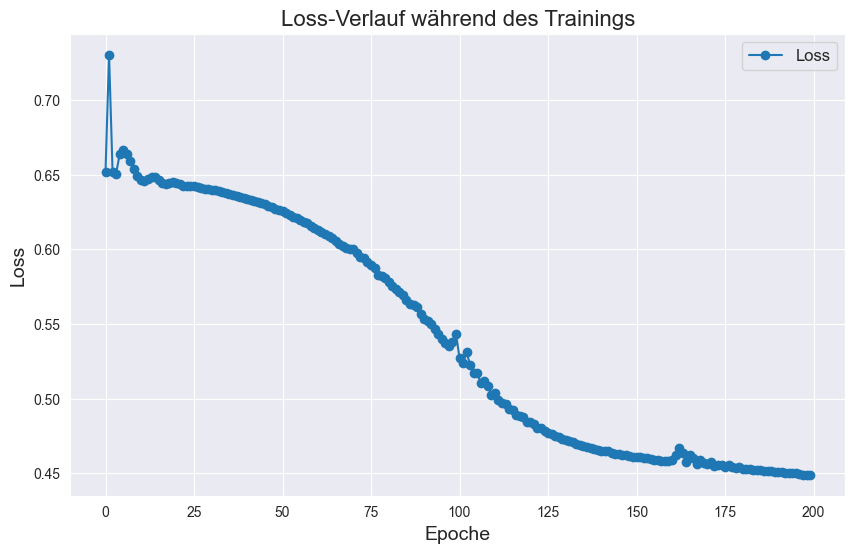

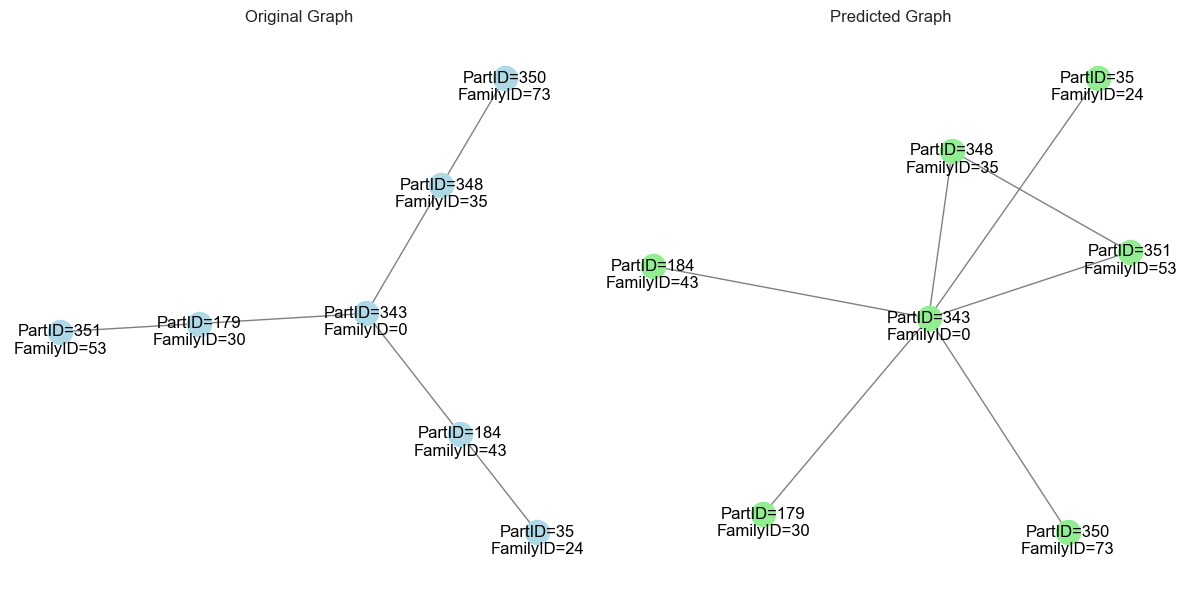

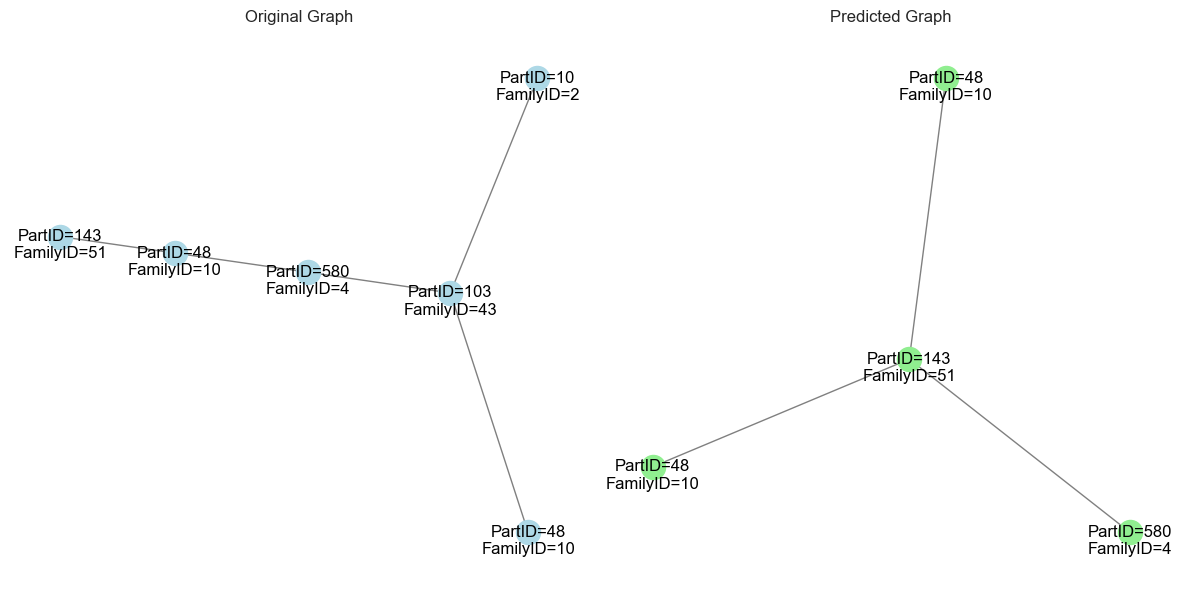

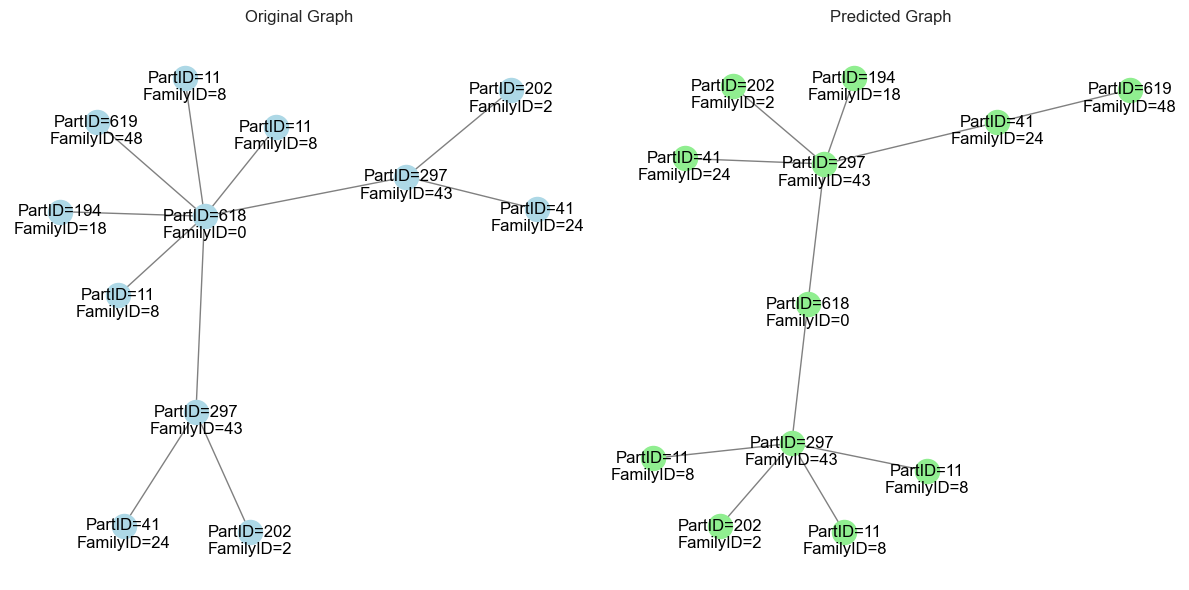

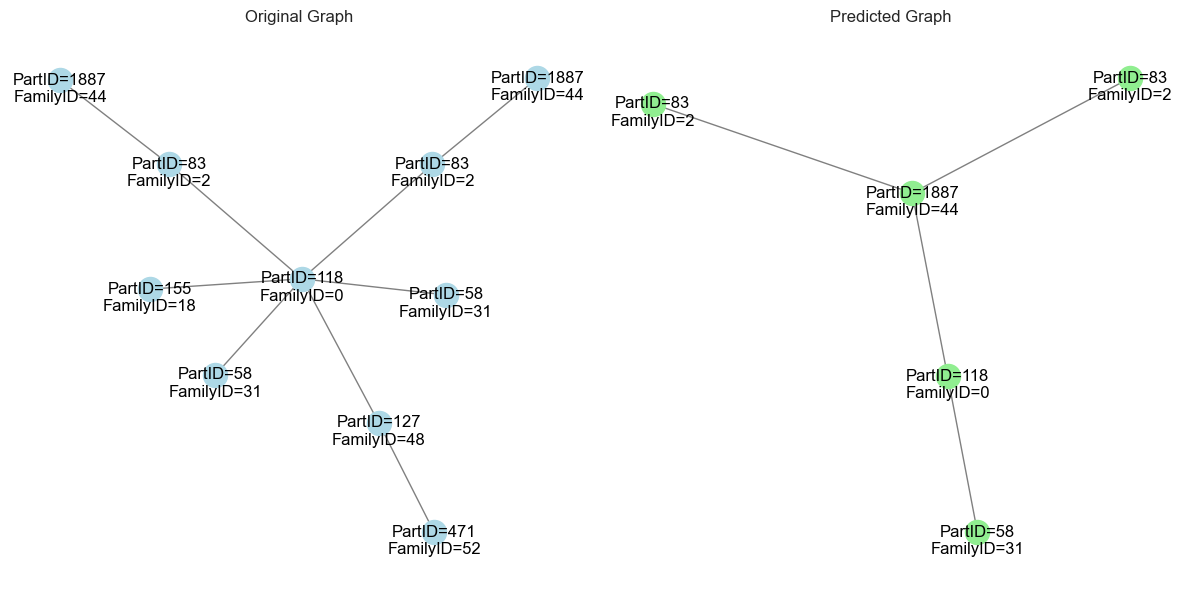

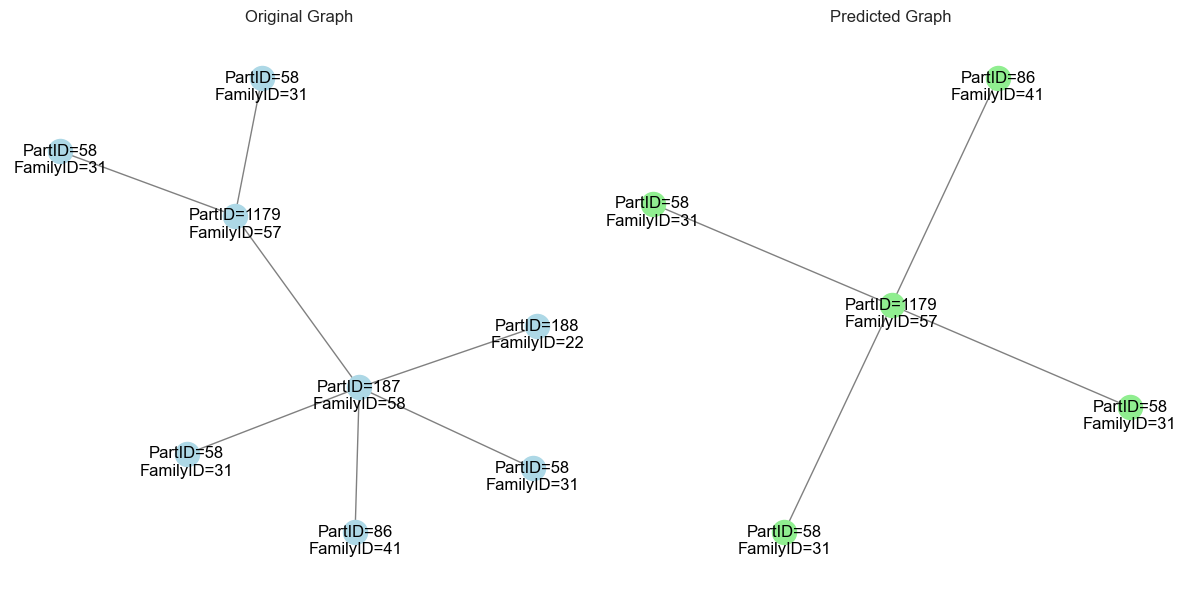

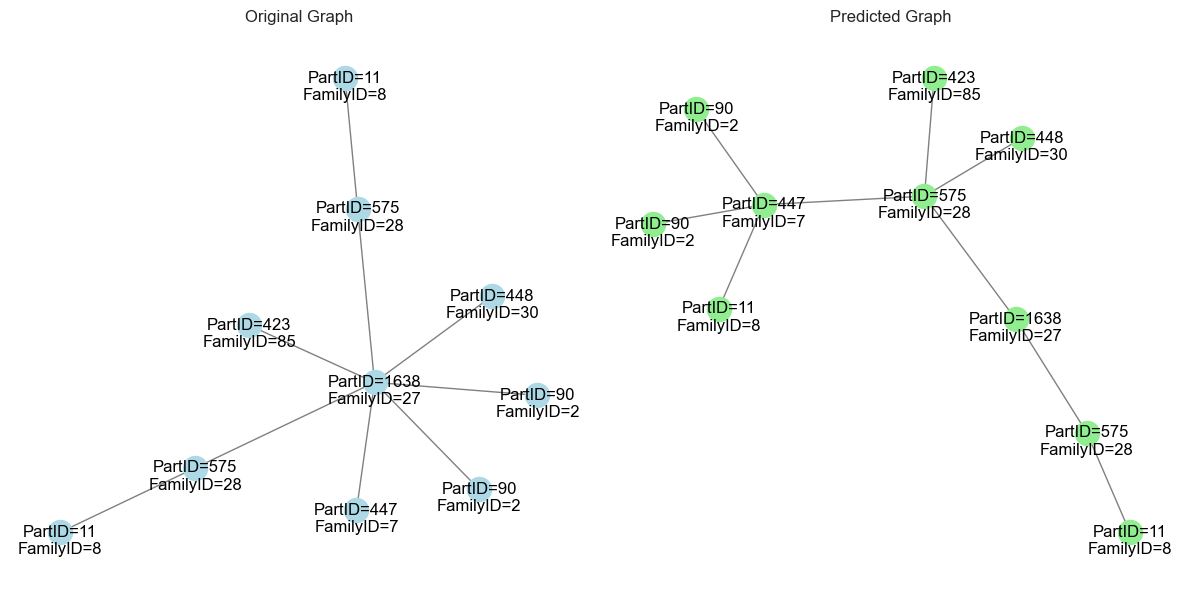

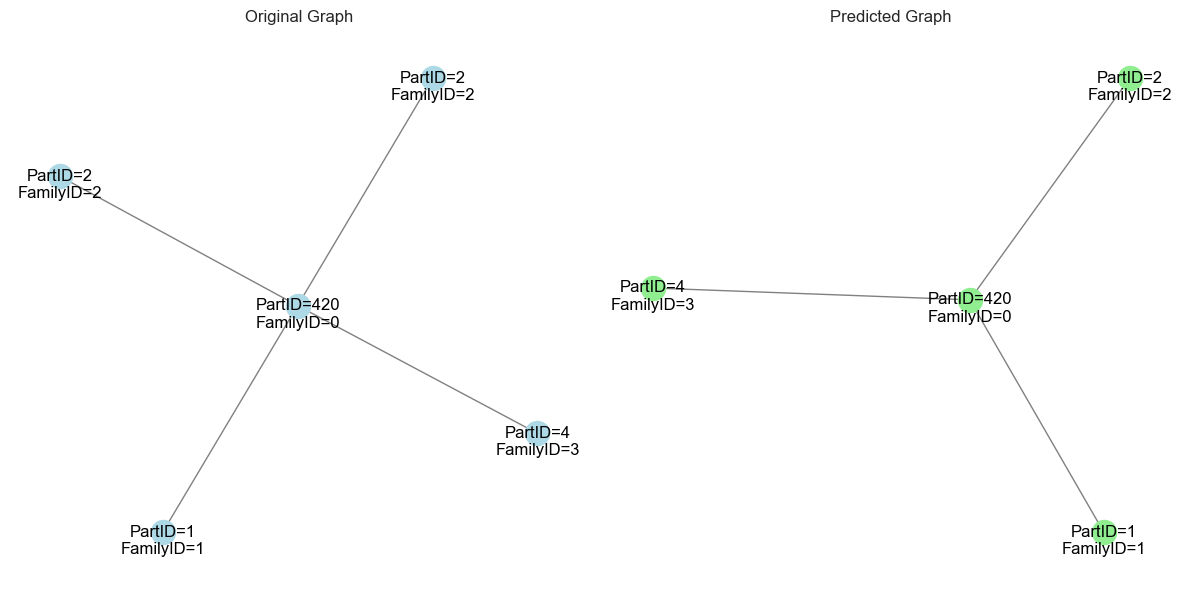

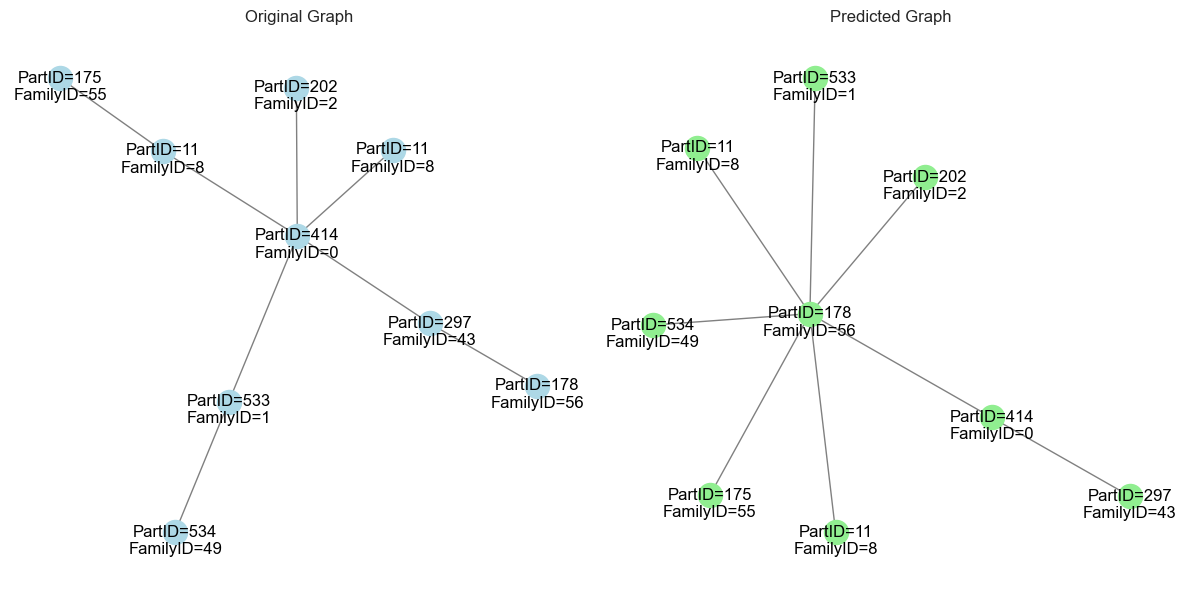

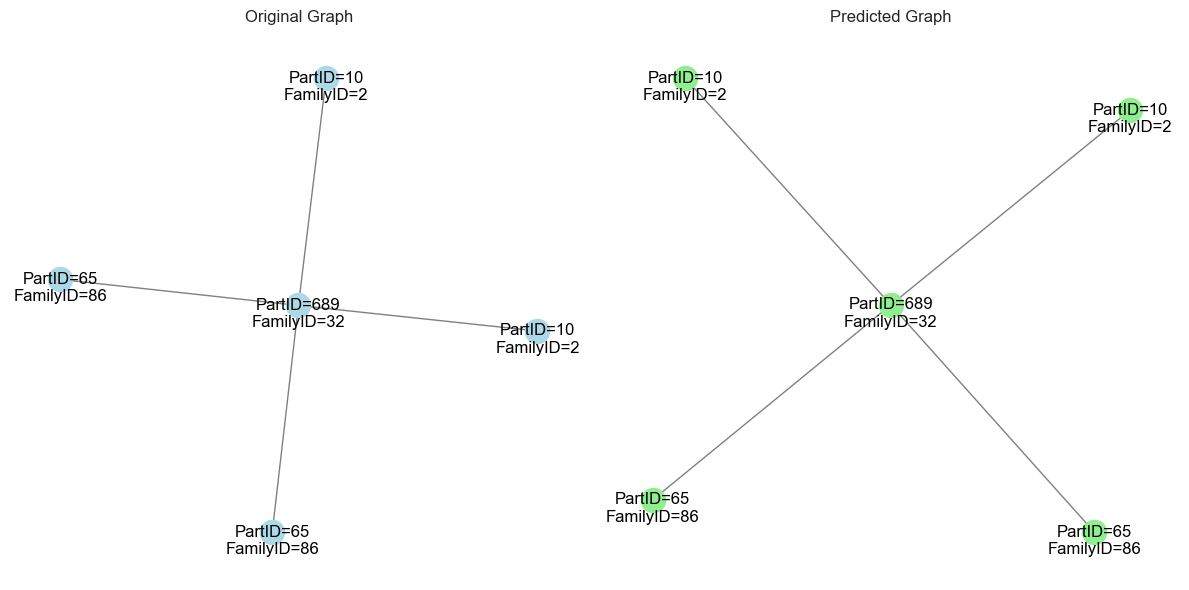

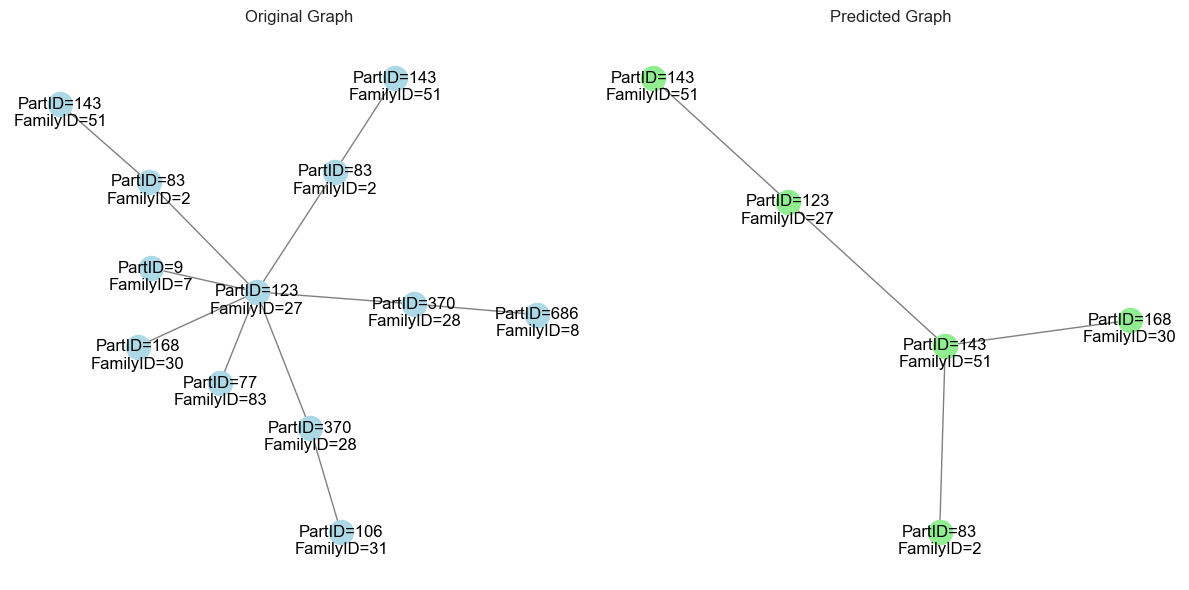

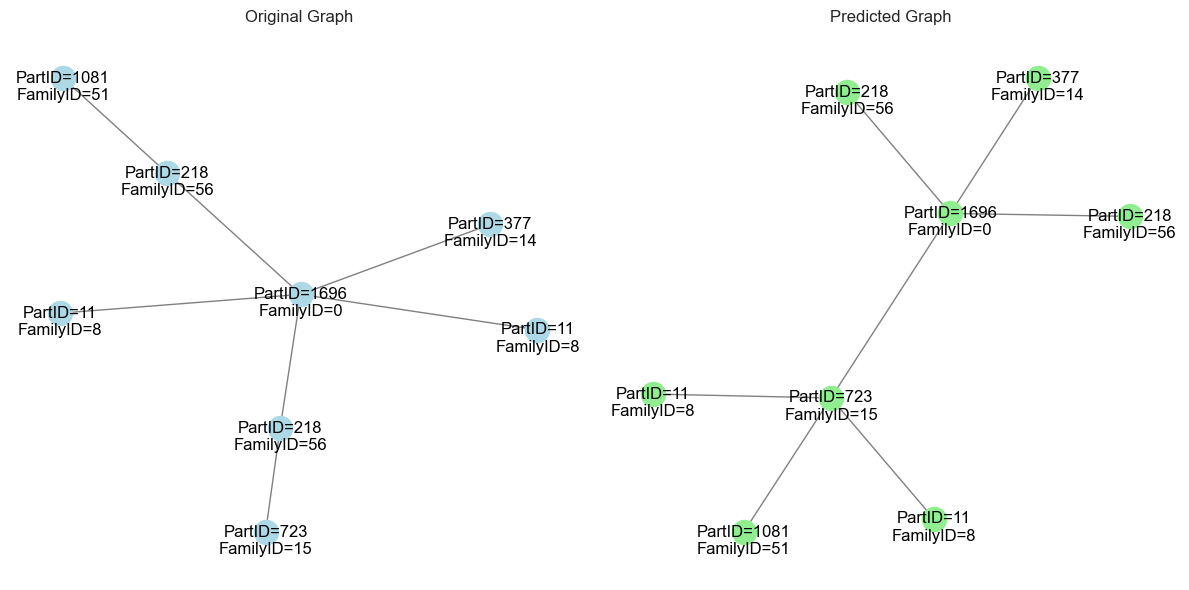

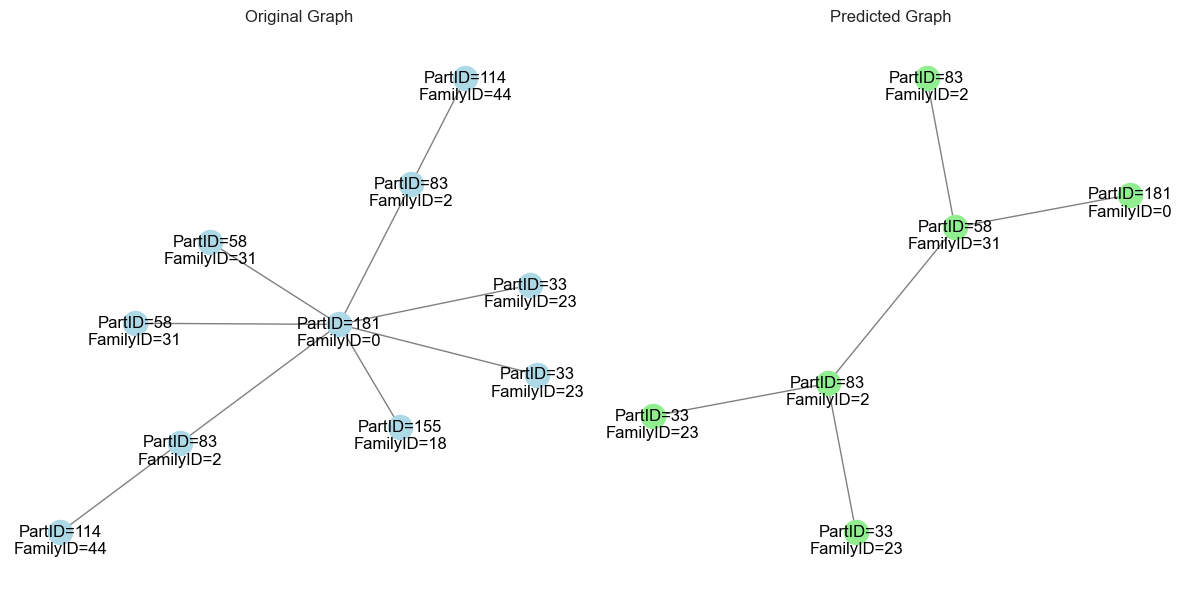

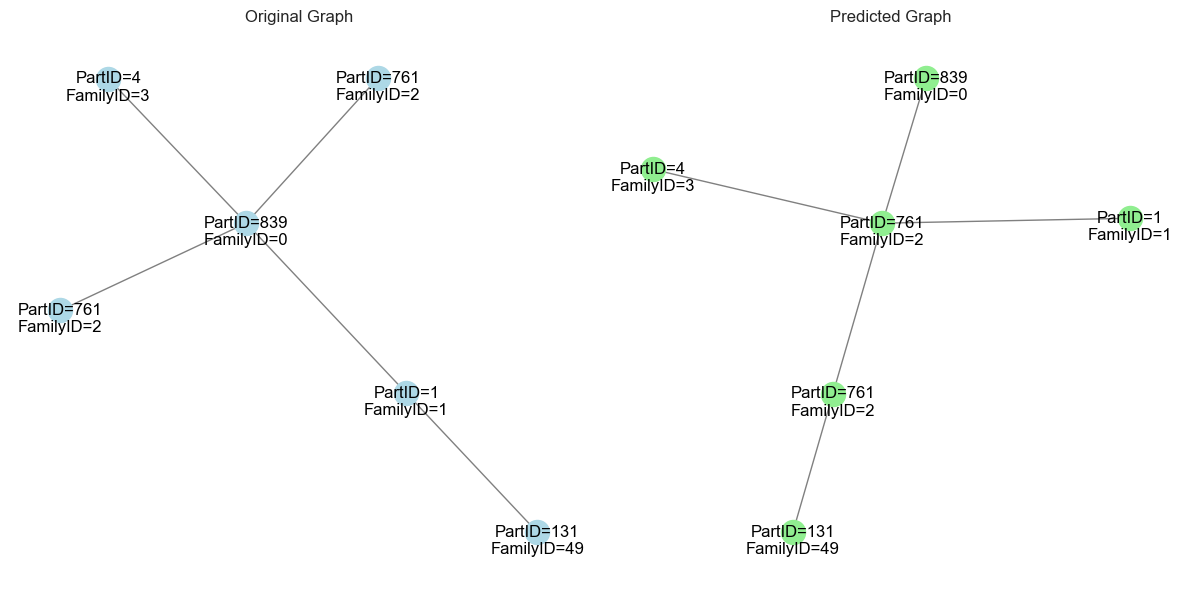

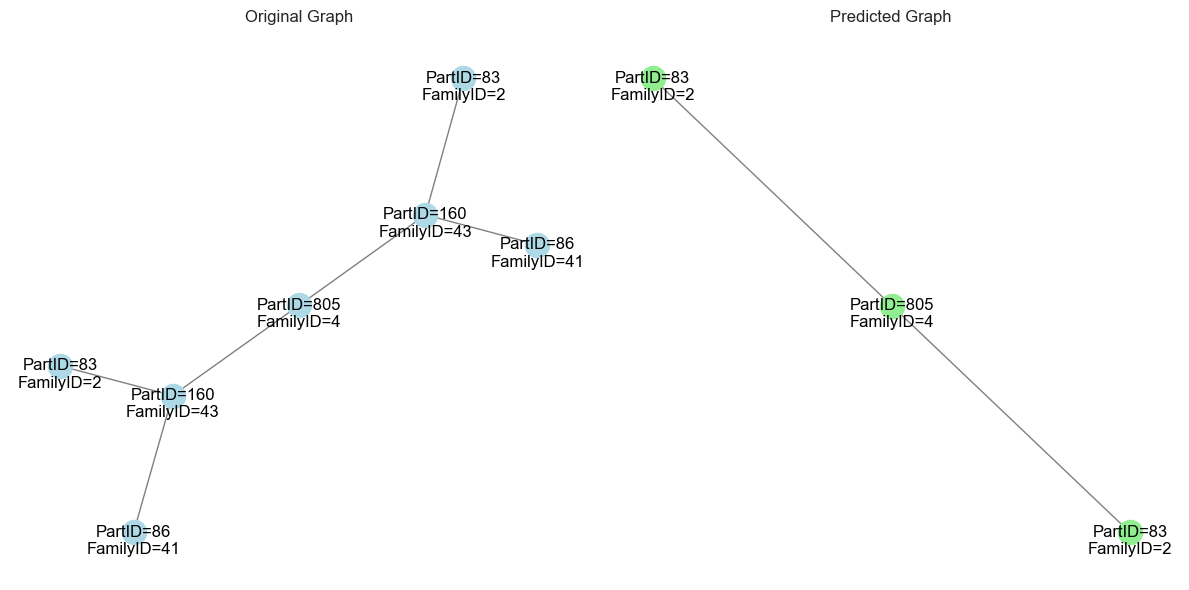

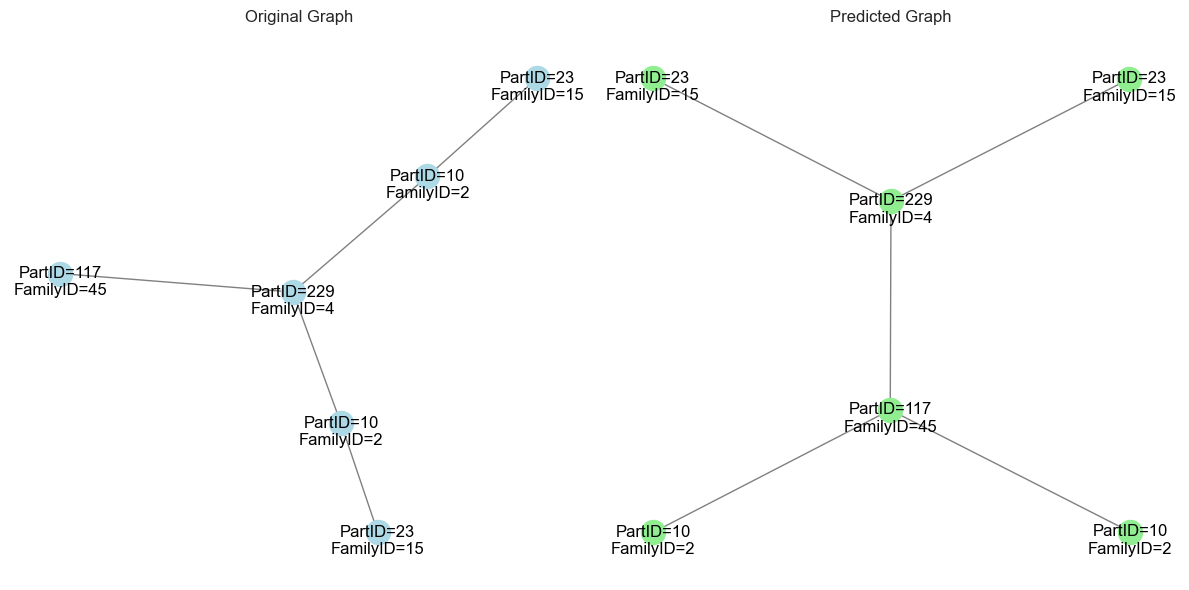

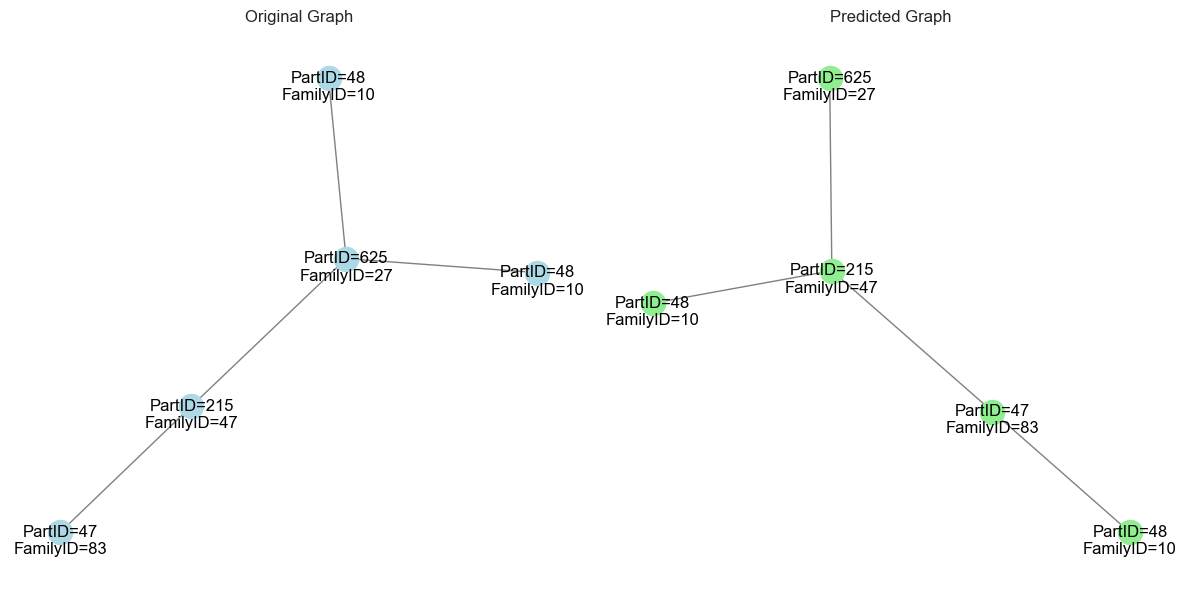

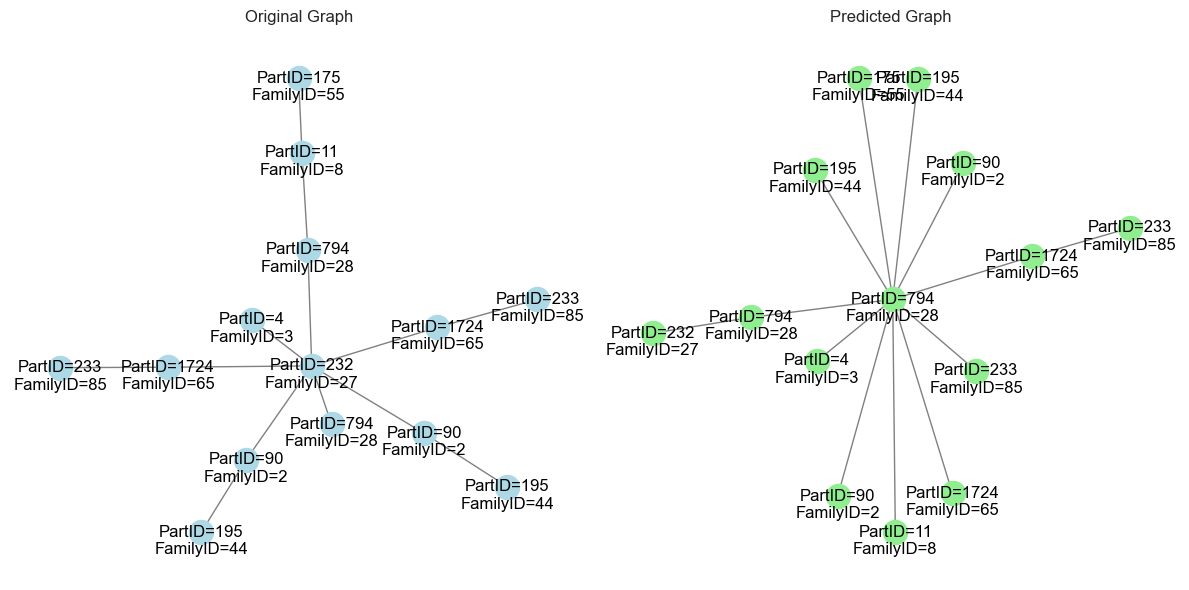

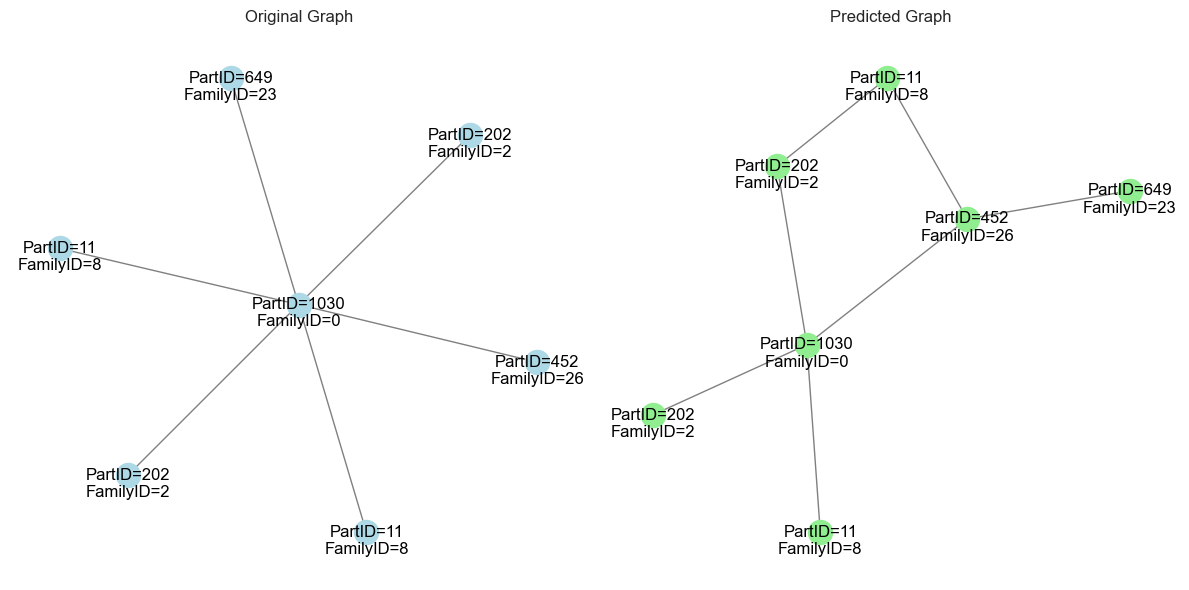

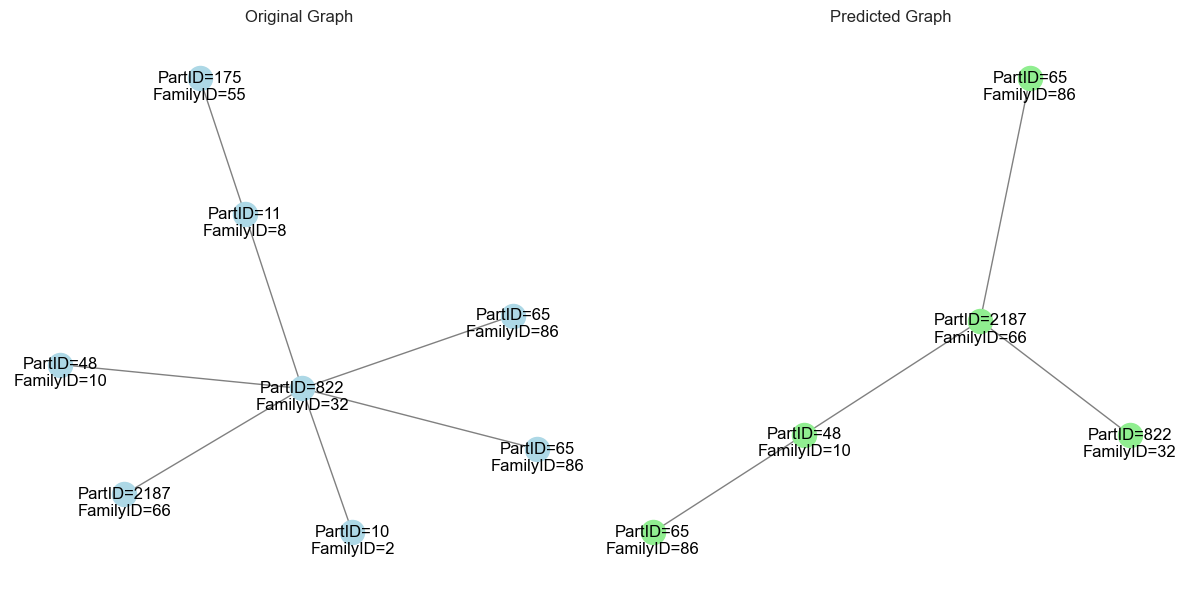

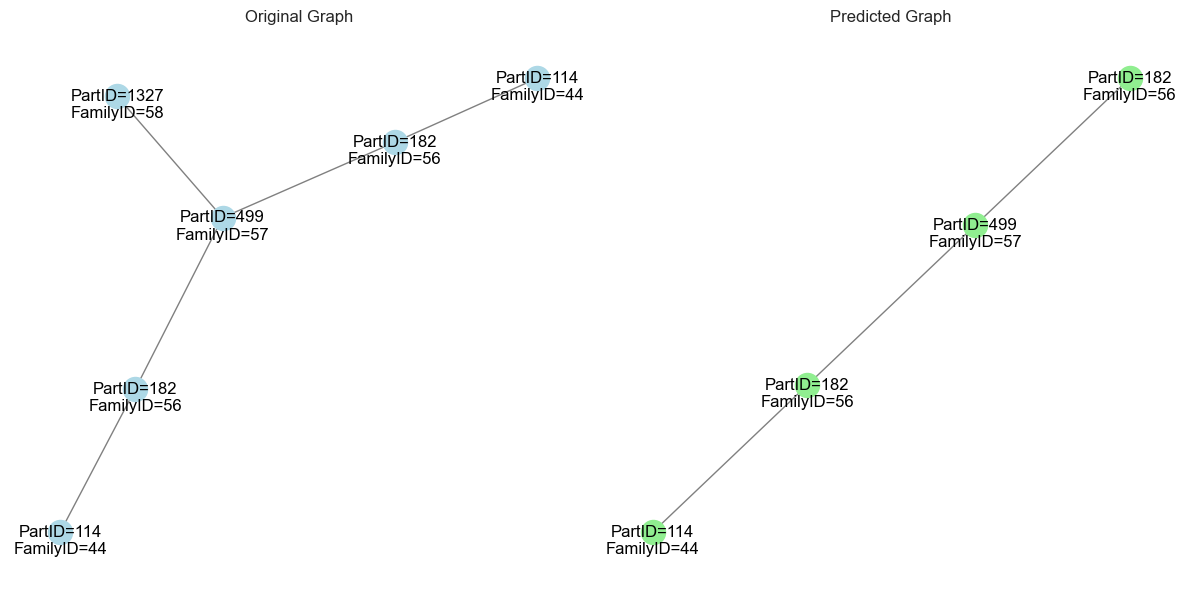

Fertig


In [10]:
# Hyperparameter
num_graphs = None  # set None for whole dataset

epochs = 200
learning_rate = 0.01
window_size = 2
edge_accept_threshold = 0.15
dimensions_w2v = 32
hidden_dimensions = int(dimensions_w2v * 2)
maximum_steps_per_graph = 10


# Pipeline

# Lade die Graphen
loaded_graphs = load_graphs_from_file(num_graphs)
train_graphs, temp_graphs = train_test_split(loaded_graphs, test_size=0.3, random_state=42)
val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.5, random_state=42)
# Konvertiere Graphen zu nx-Graphen zur Verarbeitung mit Word2Vec
nx_graphs = [g.to_nx() for g in loaded_graphs]
train_nx_graphs = [g.to_nx() for g in train_graphs]
# Trainiere Word2Vec Model
word2vec_model = train_word2vec(train_nx_graphs, dimensions=dimensions_w2v,window=window_size)

# Vorbereiten der Trainingsdaten inklusive Berechnung negativer Kanten
global_mapping = create_global_index_mapping(loaded_graphs)
train_data = prepare_training_data(train_graphs, global_mapping, word2vec_model)
val_data = prepare_training_data(val_graphs, global_mapping, word2vec_model)# Erstellung und Training des Models
gnn_model = GraphPredictorGNN(input_dim=word2vec_model.vector_size, hidden_dim=hidden_dimensions)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()

loss = train_gnn(gnn_model, optimizer, criterion, train_data, val_data, epochs=epochs)
draw_loss(loss)

# Test
average_degrees = calculate_average_degrees(nx_graphs)
build_graphs(
    graphs=test_graphs,
    word2vec_model=word2vec_model,
    gnn_model=gnn_model,
    average_degrees=average_degrees,
    edge_accept_threshold=edge_accept_threshold,
    draw=True
)
print("Fertig")

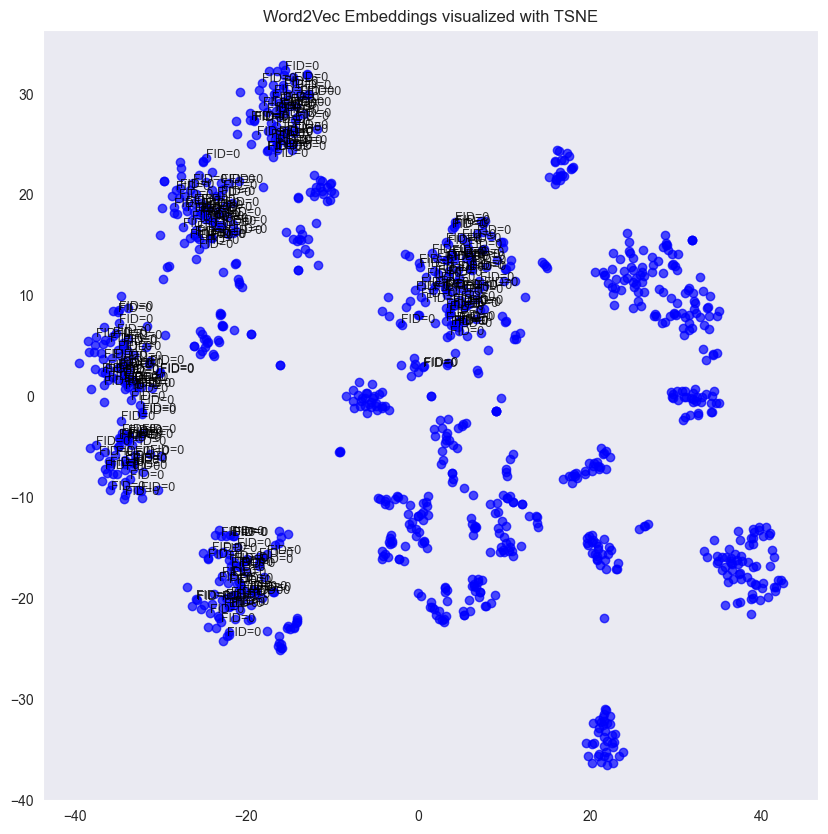

In [8]:
# Analyse: Zeichne Graphen
#for g in loaded_graphs:
#    g.draw()

# Plot Word2Vec output, also die gelernten Embeddings. Hier werden alle Parts mit Family-ID 0 angezeigt, um zu sehen, ob tatsächlich eine Ähnlichkeit besteht (Was der Fall ist)
visualize_word2vec(word2vec_model)

# Zeige testweise die ähnlichen Knoten zu einem Knoten an
#node = str(sorted(list(loaded_graphs[0].get_nodes()))[0].get_part())
#similar_nodes = word2vec_model.wv.most_similar(node, topn=5)
#print(f"Ähnliche Knoten zu {node}: {similar_nodes}")